# Y1 Dataset

In [1]:
library(ArchR)
library(parallel)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpubr)
library(dplyr)

addArchRGenome("mm10")

set.seed(147)

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats

## Initial Cell-Type Exploration and Immune Cell Filtering

In [2]:
proj <- loadArchRProject('/data/peer/sotougl/Fuchs/inflammatory_memory/scATAC/intermediate_outputs3/projects/ArchR_Y1')
proj@projectMetadata$outputDirectory = '/data/peer/sotougl/Fuchs/inflammatory_memory/scATAC/intermediate_outputs3/projects/ArchR_Y1_epdsc'
proj@projectMetadata$outputDirectory
proj

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

[1] "/data/peer/sotougl/Fuchs/inflammatory_memory/scATAC/intermediate_outputs3/projects/ArchR_Y1_epdsc"


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /data/peer/sotougl/Fuchs/inflammatory_memory/scATAC/intermediate_outputs3/projects/ArchR_Y1_epdsc 
samples(2): Y1_PIMQ Y1_Ctrl
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 17451
medianTSS(1): 10.891
medianFrags(1): 848

In [ ]:
proj <- addIterativeLSI(ArchRProj = proj,
                        useMatrix = "TileMatrix",
                        name = "IterativeLSI",
                        iterations = 2,
                        clusterParams = list(resolution = 0.2,
                                             sampleCells = 10000,
                                             n.start = 10),
                        varFeatures = 25000,
                        dimsToUse = 1:30, 
                        force=TRUE)


# Gene scores restricted to LSI-selected variable tiles
# Artificial blacklist to exclude non-variable tiles
chrom_sizes <- getChromSizes(proj)

lsi_features <- proj@reducedDims[["IterativeLSI"]]$LSIFeatures

lsi_feature_gr <- GRanges(lsi_features$seqnames, IRanges(lsi_features$start, lsi_features$start + 500))

blacklist <- IRanges::setdiff(chrom_sizes, lsi_feature_gr)

proj <- addGeneScoreMatrix(proj, matrixName='GeneScoreMatrix', force=TRUE, blacklist=blacklist)


# Cluster and embed on NFR fragments
proj <- addClusters(input = proj, reducedDims = "IterativeLSI", resolution = 0.2, force = TRUE)

# UMAP embedding
proj <- addUMAP(ArchRProj = proj,
                reducedDims = "IterativeLSI",
                name = "UMAP",
                nNeighbors = 30,
                minDist = 0.5,
                metric = "cosine", force = TRUE)

# Plot UMAP with sample/cluster labels and Ptprc gene score
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", size = 0.1, rastr = TRUE, 
                    name = "Sample", embedding = "UMAP", labelSize = 0)
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", size = 0.1, rastr = TRUE,
                    name = "Clusters", embedding = "UMAP", labelSize = 0)
p3 <- plotEmbedding(ArchRProj = proj, colorBy = 'GeneScoreMatrix', name = 'Ptprc', embedding = "UMAP",
                    imputeWeights = getImputeWeights(proj), colorLimit = NULL, plotAs = "points")

ggsave('../intermediate_outputs3/plots/step00_Y1_all_cells.pdf', ggarrange(p1,p2,p3))
ggarrange(p1, p2, p3)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-1f91f12a34e00-Date-2025-01-04_Time-22-56-11.001457.log
If there is an issue, please report to github with logFile!

2025-01-04 22:56:20.50479 : Computing Total Across All Features, 0.144 mins elapsed.

2025-01-04 22:56:24.15637 : Computing Top Features, 0.205 mins elapsed.

###########
2025-01-04 22:56:25.179127 : Running LSI (1 of 2) on Top Features, 0.222 mins elapsed.
###########

2025-01-04 22:56:25.230873 : Sampling Cells (N = 10001) for Estimated LSI, 0.223 mins elapsed.

2025-01-04 22:56:25.232875 : Creating Sampled Partial Matrix, 0.223 mins elapsed.

2025-01-04 22:56:44.343587 : Computing Estimated LSI (projectAll = FALSE), 0.541 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2025-01-04 22:57:10.643896 : Identifying Clusters, 0.98 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2025-01-04 22:57:25.413211 : Identified 18 Clusters, 1.226 mins elapsed.



************************************************************
2025-01-04 22:57:48.91711 : ERROR Found in .saveIteration for  
LogFile = ArchRLogs/ArchR-addIterativeLSI-1f91f12a34e00-Date-2025-01-04_Time-22-56-11.001457.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2025-01-04 22:57:48.919802 : Creating Cluster Matrix on the total Group Features, 1.618 mins elapsed.

2025-01-04 22:58:28.428873 : Computing Variable Features, 2.276 mins elapsed.

###########
2025-01-04 22:58:28.842357 : Running LSI (2 of 2) on Variable Features, 2.283 mins elapsed.
###########

2025-01-04 22:58:28.860053 : Creating Partial Matrix, 2.283 mins elapsed.

2025-01-04 22:58:58.071521 : Computing LSI, 2.77 mins elapsed.

2025-01-04 22:59:22.277166 : Finished Running IterativeLSI, 3.174 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-addGeneScoreMatrix-1f91fb297c63-Date-2025-01-04_Time-22-59-22.426017.log
If there is an issue, please report to github with logFile!

2025-01-04 22:59:22.550303 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17451
Number of edges: 490544

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8906
Number of communities: 49
Elapsed time: 2 seconds


27 singletons identified. 22 final clusters.

2025-01-04 23:04:06.05997 : Testing Biased Clusters, 0.315 mins elapsed.

2025-01-04 23:04:06.349189 : Testing Outlier Clusters, 0.32 mins elapsed.

2025-01-04 23:04:06.353168 : Assigning Cluster Names to 22 Clusters, 0.32 mins elapsed.

2025-01-04 23:04:06.424909 : Finished addClusters, 0.321 mins elapsed.

23:04:06 UMAP embedding parameters a = 0.583 b = 1.334

23:04:06 Read 17451 rows and found 30 numeric columns

23:04:06 Using Annoy for neighbor search, n_neighbors = 30

23:04:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:04:09 Writing NN index file to temp file /scratch/lsftmp/11530346.tmpdir/RtmplRqyL4/file1f91fd5b556

23:04:09 Searching Annoy index using 64 threads, search_k = 3000

23:04:12 Annoy recall = 9

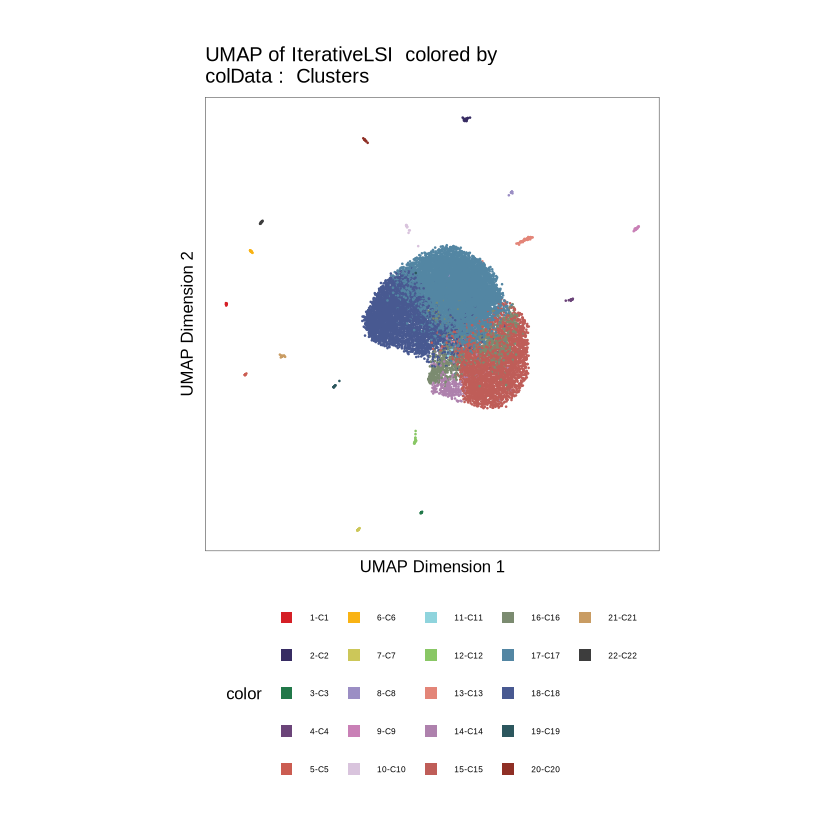

In [5]:
p2

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f1798ffba-Date-2025-01-04_Time-23-08-12.081647.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f1798ffba-Date-2025-01-04_Time-23-08-12.081647.log



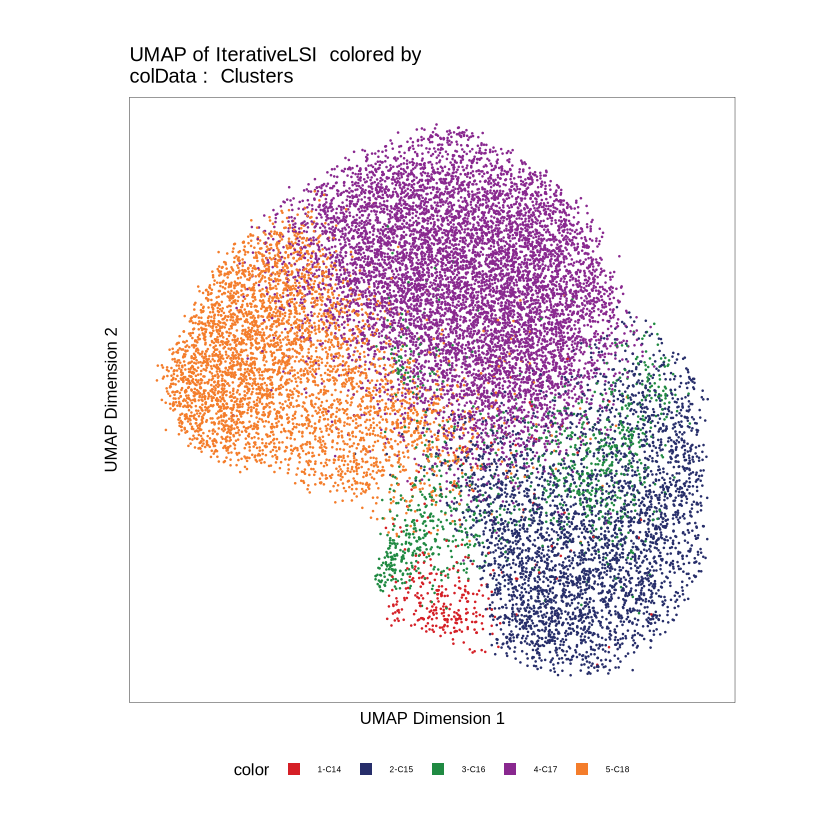

In [ ]:
# Restrict to epithelial stem cell clusters (C14-C18)
epdsc_clusters <- c('C14', 'C15', 'C16', 'C17', 'C18')
epdsc_idx <- which(proj$Clusters %in% epdsc_clusters)
epdsc_cells <- proj$cellNames[epdsc_idx]
proj_epdsc <- proj[epdsc_cells,]
plotEmbedding(ArchRProj = proj_epdsc, colorBy = "cellColData", size = 0.1, rastr = TRUE,
                    name = "Clusters", embedding = "UMAP", labelSize = 0)

Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f1124bf0d-Date-2025-01-04_Time-23-08-18.836477.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2025-01-04 23:08:18.999863 : 

1 
2 


Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f1124bf0d-Date-2025-01-04_Time-23-08-18.836477.log



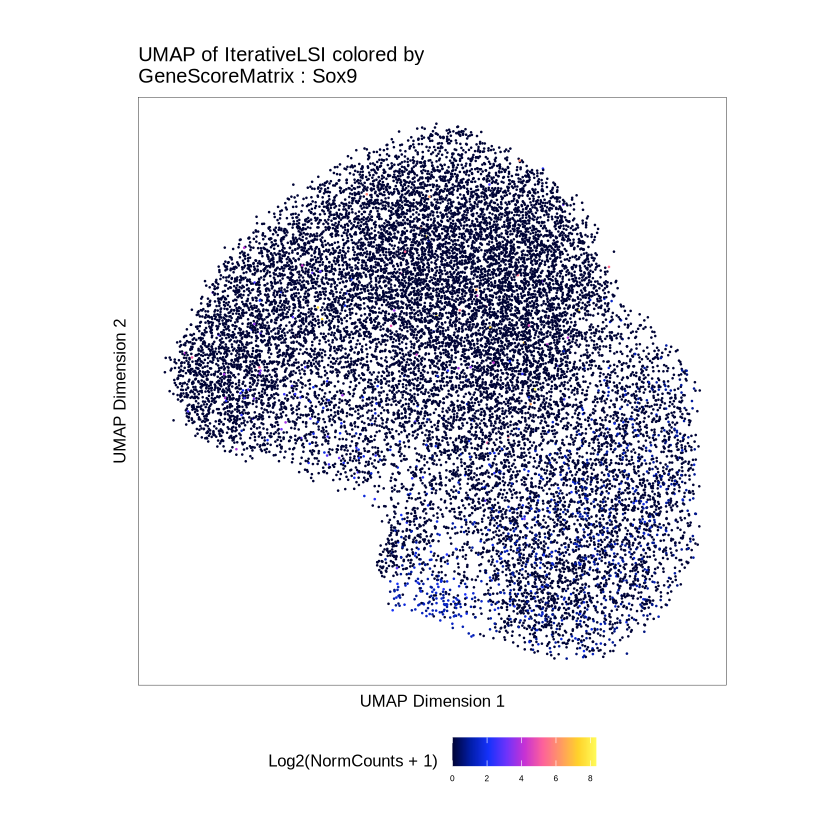

In [ ]:
plotEmbedding(ArchRProj = proj_epdsc,
              colorBy = 'GeneScoreMatrix',
              name = 'Sox9',
              embedding = "UMAP",
              imputeWeights = getImputeWeights(proj_epdsc),
              quantCut = c(0.1, 0.4),
              colorLimit = NULL,
              plotAs = "points")

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f3e7c4523-Date-2025-01-04_Time-23-08-32.166211.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f3e7c4523-Date-2025-01-04_Time-23-08-32.166211.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f8739644-Date-2025-01-04_Time-23-08-32.445219.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f8739644-Date-2025-01-04_Time-23-08-32.445219.log

Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f1d091fed-Date-2025-01-04_Time-23-08-32.726753.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix 

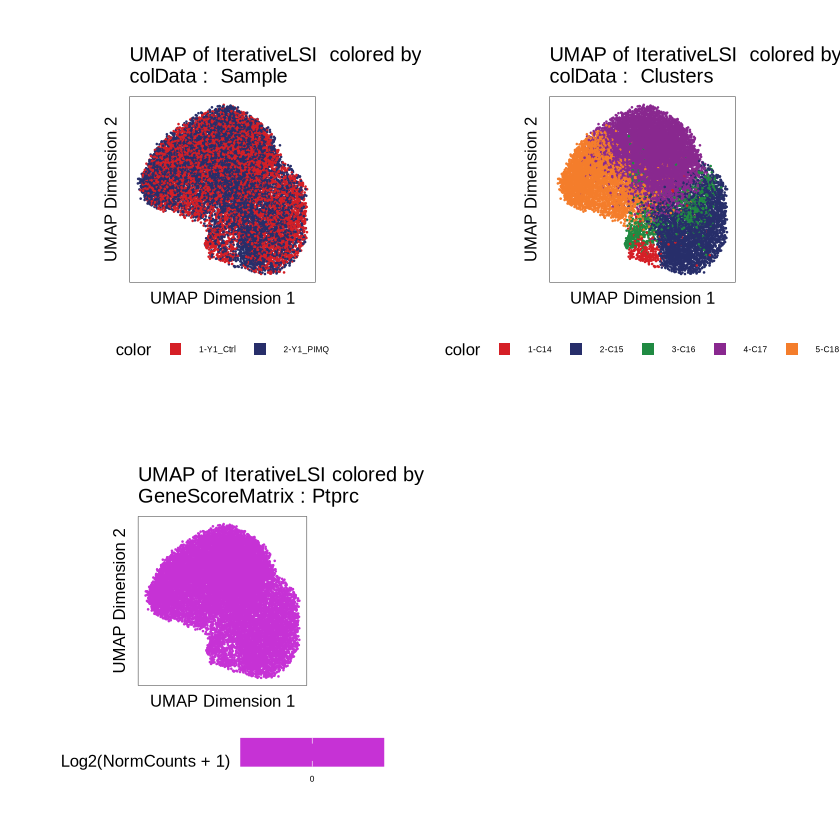

In [ ]:
# Restrict to epithelial stem cell clusters and plot
epdsc_clusters <- c('C14', 'C15', 'C16', 'C17', 'C18')
epdsc_idx <- which(proj$Clusters %in% epdsc_clusters)
epdsc_cells <- proj$cellNames[epdsc_idx]
proj_epdsc <- proj[epdsc_cells,]

# Plot UMAP colored by sample, cluster, and Ptprc gene score
p1 <- plotEmbedding(ArchRProj = proj_epdsc, colorBy = "cellColData", size = 0.1, rastr = TRUE, 
                    name = "Sample", embedding = "UMAP", labelSize = 0)
p2 <- plotEmbedding(ArchRProj = proj_epdsc, colorBy = "cellColData", size = 0.1, rastr = TRUE,
                    name = "Clusters", embedding = "UMAP", labelSize = 0)
p3 <- plotEmbedding(ArchRProj = proj_epdsc, colorBy = 'GeneScoreMatrix', name = 'Ptprc', embedding = "UMAP",
                    imputeWeights = getImputeWeights(proj_epdsc), colorLimit = NULL, plotAs = "points")
ggsave('../intermediate_outputs3/step01_Y1_epdsc_cells.pdf', ggarrange(p1,p2,p3))
ggarrange(p1, p2, p3)

In [ ]:
# Cell counts per sample
proj_epdsc@cellColData %>% as.data.frame() %>% group_by(Sample) %>% summarize(n = n())

Sample,n
<chr>,<int>
Y1_Ctrl,8010
Y1_PIMQ,9117


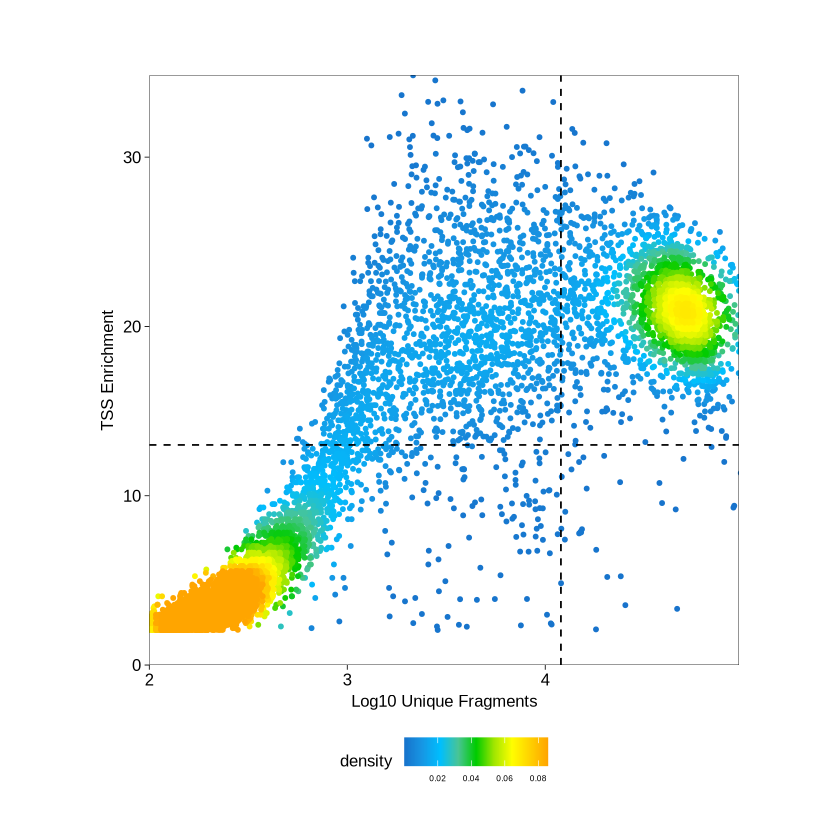

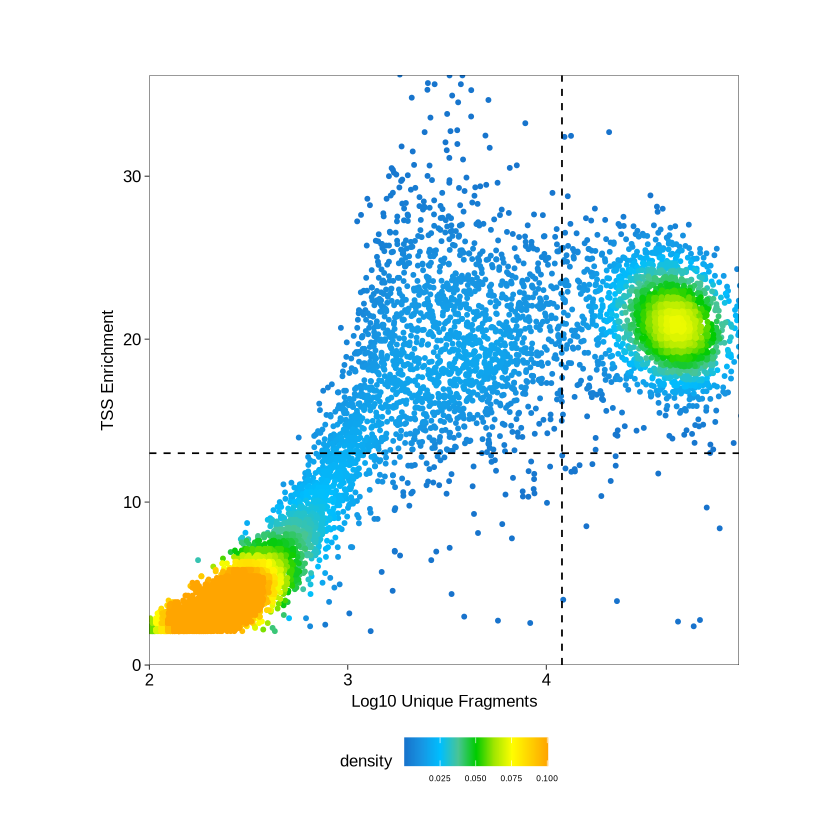

In [ ]:
# QC scatterplots per sample (log10 fragments vs TSS enrichment)
df <- getCellColData(proj_epdsc[proj_epdsc$Sample == 'Y1_Ctrl'], select = c("log10(nFrags)", "TSSEnrichment"))
ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(100), quantile(df[,1], probs = 0.999)),
    ylim = c(0, quantile(df[,2], probs = 0.999))
) + geom_hline(yintercept = 13, lty = "dashed") +
    geom_vline(xintercept = log10(12000), lty = "dashed")

df <- getCellColData(proj_epdsc[proj_epdsc$Sample == 'Y1_PIMQ'], select = c("log10(nFrags)", "TSSEnrichment"))
ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(100), quantile(df[,1], probs = 0.999)),
    ylim = c(0, quantile(df[,2], probs = 0.999))
) + geom_hline(yintercept = 13, lty = "dashed") +
    geom_vline(xintercept = log10(12000), lty = "dashed")

In [ ]:
# Apply TSS enrichment and fragment count thresholds
sprintf( 'number of cells: %s ', nCells(proj_epdsc))
idxPass <- which(proj_epdsc$TSSEnrichment >= 13)
cellsPass <- proj_epdsc$cellNames[idxPass]
proj_epdsc <- proj_epdsc[cellsPass, ]
sprintf( 'number of cells: %s ', nCells(proj_epdsc))
idxPass <- which(proj_epdsc$nFrags >= 12000)
cellsPass <- proj_epdsc$cellNames[idxPass]
proj_epdsc <- proj_epdsc[cellsPass, ]
sprintf( 'number of cells: %s ', nCells(proj_epdsc))

[1] "number of cells: 17127 "

[1] "number of cells: 8022 "

[1] "number of cells: 4622 "

In [ ]:
# Cell counts per sample after QC
proj_epdsc@cellColData %>% as.data.frame() %>% group_by(Sample) %>% summarize(n = n())

Sample,n
<chr>,<int>
Y1_Ctrl,2242
Y1_PIMQ,2380


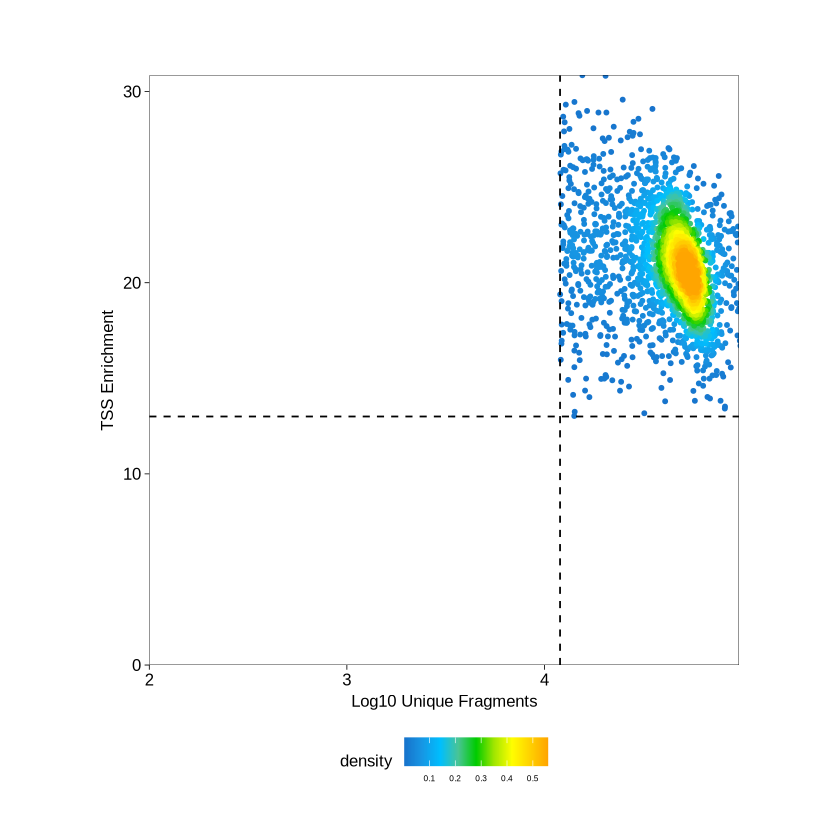

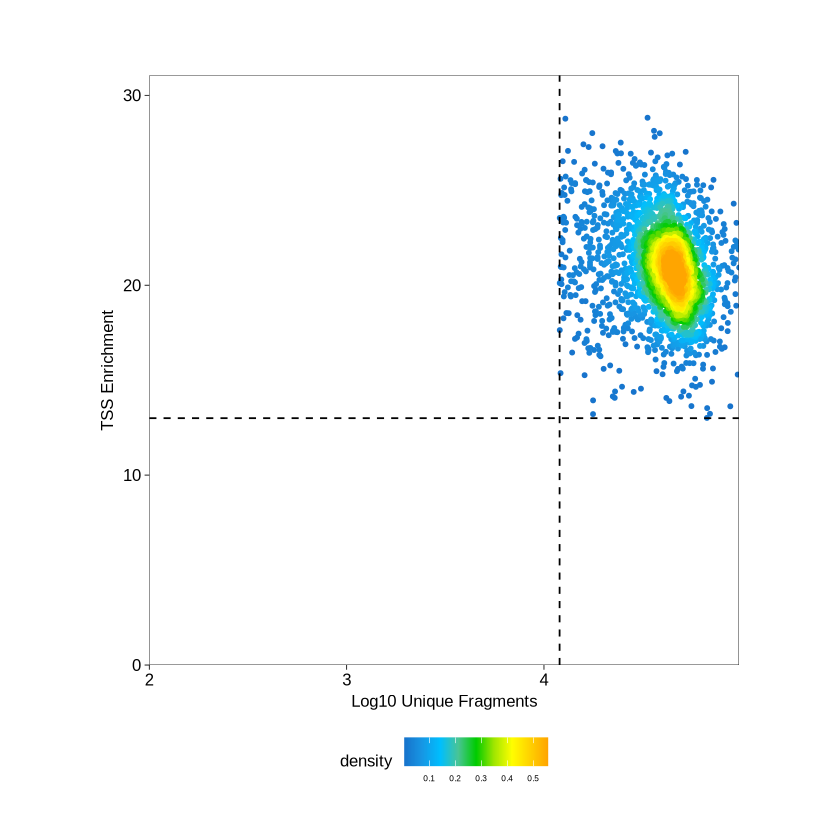

In [ ]:
# Verify QC metrics after filtering
df <- getCellColData(proj_epdsc[proj_epdsc$Sample == 'Y1_Ctrl'], select = c("log10(nFrags)", "TSSEnrichment"))
ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(100), quantile(df[,1], probs = 0.999)),
    ylim = c(0, quantile(df[,2], probs = 0.999))
) + geom_hline(yintercept = 13, lty = "dashed") + geom_vline(xintercept = log10(12000), lty = "dashed")

df <- getCellColData(proj_epdsc[proj_epdsc$Sample == 'Y1_PIMQ'], select = c("log10(nFrags)", "TSSEnrichment"))
ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(100), quantile(df[,1], probs = 0.999)),
    ylim = c(0, quantile(df[,2], probs = 0.999))
) + geom_hline(yintercept = 13, lty = "dashed") + geom_vline(xintercept = log10(12000), lty = "dashed")

In [ ]:
# Doublet detection and filtering
proj_epdsc <- addDoubletScores(
  input = proj_epdsc,
  k = 10, # Number of nearest neighbors for pseudo-doublet scoring
  knnMethod = "UMAP", # Embedding used for kNN search
  LSIMethod = 1
)

proj_epdsc <- filterDoublets(proj_epdsc)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-1f91f231151fe-Date-2025-01-04_Time-23-10-10.143608.log
If there is an issue, please report to github with logFile!

2025-01-04 23:10:10.259399 : Batch Execution w/ safelapply!, 0 mins elapsed.

2025-01-04 23:10:10.266953 : Y1_PIMQ (1 of 2) :  Computing Doublet Statistics, 0 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Y1_PIMQ (1 of 2) : UMAP Projection R^2 = 0.98299

Y1_PIMQ (1 of 2) : UMAP Projection R^2 = 0.98299



Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the ArchR package.
  Please report the issue to the authors.”





************************************************************
2025-01-04 23:13:04.465245 : ERROR Found in ggplot for Y1_PIMQ (1 of 2) :  
LogFile = ArchRLogs/ArchR-addDoubletScores-1f91f231151fe-Date-2025-01-04_Time-23-10-10.143608.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2025-01-04 23:13:04.521032 : Y1_Ctrl (2 of 2) :  Computing Doublet Statistics, 2.904 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Y1_Ctrl (2 of 2) : UMAP Projection R^2 = 0.99127

Y1_Ctrl (2 of 2) : UMAP Projection R^2 = 0.99127








************************************************************
2025-01-04 23:15:32.978735 : ERROR Found in ggplot for Y1_Ctrl (2 of 2) :  
LogFile = ArchRLogs/ArchR-addDoubletScores-1f91f231151fe-Date-2025-01-04_Time-23-10-10.143608.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-1f91f231151fe-Date-2025-01-04_Time-23-10-10.143608.log

Filtering 106 cells from ArchRProject!

	Y1_PIMQ : 56 of 2380 (2.4%)

	Y1_Ctrl : 50 of 2242 (2.2%)



In [ ]:
# Recompute LSI/UMAP on filtered EpdSC subset
proj_epdsc <- addIterativeLSI(ArchRProj = proj_epdsc,
                        useMatrix = "TileMatrix",
                        name = "IterativeLSI",
                        iterations = 3,
                        seed = 1,
                        clusterParams = list(resolution = c(0.2, 0.5),
                                             sampleCells = 3000,
                                             n.start = 10),
                        varFeatures = 20000,
                        dimsToUse = 1:30, force = TRUE)

# Clustering on LSI
proj_epdsc <- addClusters(input = proj_epdsc,
                    reducedDims = "IterativeLSI",
                    method = "Seurat",
                    name = "Clusters",
                    resolution = 0.2, force = TRUE)

# UMAP embedding
proj_epdsc <- addUMAP(ArchRProj = proj_epdsc,
                reducedDims = "IterativeLSI",
                name = "UMAP",
                nNeighbors = 30,
                minDist = 0.5,
                metric = "cosine", force = TRUE)


Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-1f91f6dfcd778-Date-2025-01-04_Time-23-18-19.10915.log
If there is an issue, please report to github with logFile!

2025-01-04 23:18:19.855823 : Computing Total Across All Features, 0.01 mins elapsed.

2025-01-04 23:18:20.703844 : Computing Top Features, 0.024 mins elapsed.

###########
2025-01-04 23:18:22.00247 : Running LSI (1 of 3) on Top Features, 0.046 mins elapsed.
###########

2025-01-04 23:18:22.018318 : Creating Partial Matrix, 0.046 mins elapsed.

2025-01-04 23:18:43.728835 : Computing LSI, 0.408 mins elapsed.

2025-01-04 23:19:11.063398 : Identifying Clusters, 0.864 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2025-01-04 23:19:15.035374 : Identified 5 Clusters, 0.93 mins elapsed.

2025-01-04 23:19:15.041677 : Saving LSI Iteration, 0.93 mins elapsed.






************************************************************
2025-01-04 23:19:27.522713 : ERROR Found in .saveIteration for  
LogFile = ArchRLogs/ArchR-addIterativeLSI-1f91f6dfcd778-Date-2025-01-04_Time-23-18-19.10915.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2025-01-04 23:19:27.524698 : Creating Cluster Matrix on the total Group Features, 1.138 mins elapsed.

2025-01-04 23:20:15.151839 : Computing Variable Features, 1.932 mins elapsed.

###########
2025-01-04 23:20:15.289673 : Running LSI (2 of 3) on Variable Features, 1.934 mins elapsed.
###########

2025-01-04 23:20:15.305988 : Creating Partial Matrix, 1.934 mins elapsed.

2025-01-04 23:20:35.400773 : Computing LSI, 2.269 mins elapsed.

2025-01-04 23:20:51.24667 : Identifying Clusters, 2.533 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2025-01-04 23:20:55.11058 : Identified 7 Clusters, 2.598 mins elapsed.

2025-01-04 23:20:55.116968 : Saving LSI Iteration, 2.598 mins elapsed.






************************************************************
2025-01-04 23:21:06.998347 : ERROR Found in .saveIteration for  
LogFile = ArchRLogs/ArchR-addIterativeLSI-1f91f6dfcd778-Date-2025-01-04_Time-23-18-19.10915.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2025-01-04 23:21:07.670173 : Creating Cluster Matrix on the total Group Features, 2.807 mins elapsed.

2025-01-04 23:21:55.095002 : Computing Variable Features, 3.598 mins elapsed.

###########
2025-01-04 23:21:55.269597 : Running LSI (3 of 3) on Variable Features, 3.6 mins elapsed.
###########

2025-01-04 23:21:55.28583 : Creating Partial Matrix, 3.601 mins elapsed.

2025-01-04 23:22:14.778988 : Computing LSI, 3.926 mins elapsed.

2025-01-04 23:22:30.101717 : Finished Running IterativeLSI, 4.181 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-addClusters-1f91f317f2643-Date-2025-01-04_Time-23-22-30.111231.log
If there is an issue, please report to github with logFile!

Overriding previous entry for Clusters

2025-01-04 23:22:30.264461 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4516
Number of edges: 151517

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8933
Number of communities: 8
Elapsed time: 0 seconds


2025-01-04 23:22:34.682378 : Testing Biased Clusters, 0.074 mins elapsed.

2025-01-04 23:22:34.733066 : Testing Outlier Clusters, 0.075 mins elapsed.

2025-01-04 23:22:34.735992 : Assigning Outlier Clusters (n = 1, nOutlier < 5 cells) to Neighbors, 0.075 mins elapsed.

2025-01-04 23:22:34.744551 : Assigning Cluster Names to 7 Clusters, 0.076 mins elapsed.

2025-01-04 23:22:34.777627 : Finished addClusters, 0.076 mins elapsed.

23:22:34 UMAP embedding parameters a = 0.583 b = 1.334

23:22:34 Read 4516 rows and found 30 numeric columns

23:22:34 Using Annoy for neighbor search, n_neighbors = 30

23:22:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:22:35 Writing NN index file to temp file /scratch/lsftmp/11530346.tmpdir/RtmplRqyL4/file1f91f6a834190

23:22:35 Search

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91fc2e88af-Date-2025-01-04_Time-23-23-00.134496.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91fc2e88af-Date-2025-01-04_Time-23-23-00.134496.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f6ede5725-Date-2025-01-04_Time-23-23-00.867671.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f6ede5725-Date-2025-01-04_Time-23-23-00.867671.log



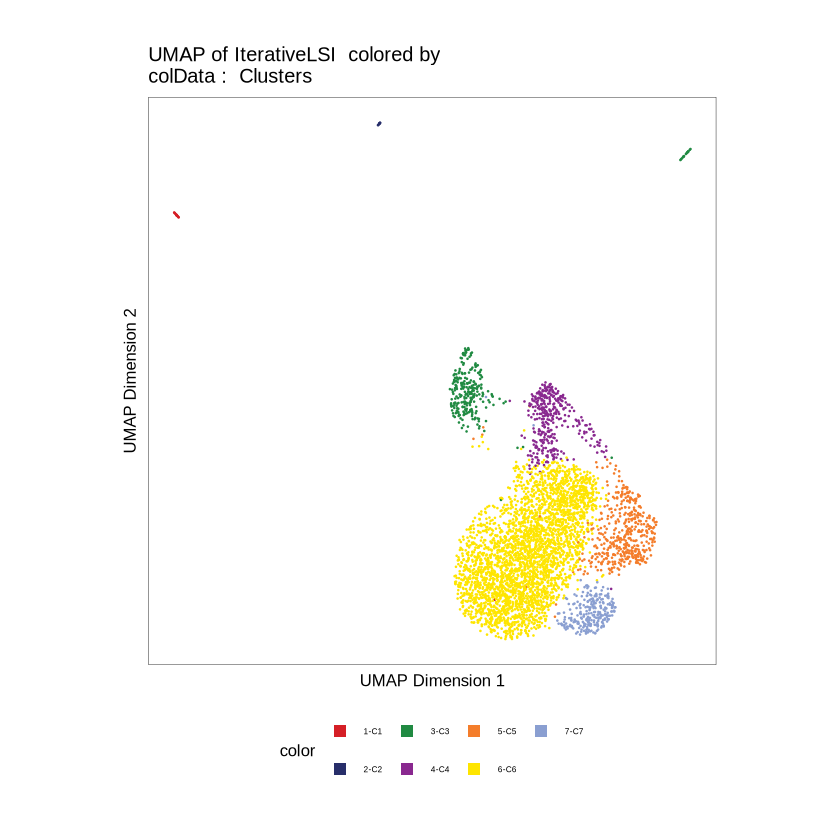

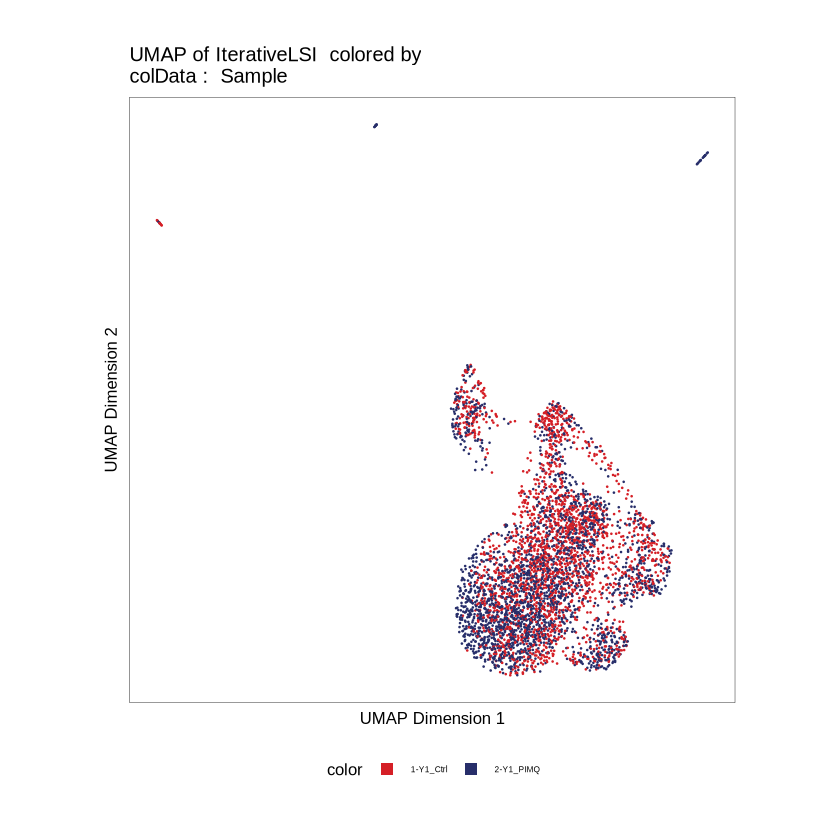

In [ ]:
plotEmbedding(ArchRProj = proj_epdsc, colorBy = "cellColData", size = 0.1, rastr = TRUE,
                    name = "Clusters", embedding = "UMAP", labelSize = 0)
plotEmbedding(ArchRProj = proj_epdsc, colorBy = "cellColData", size = 0.1, rastr = TRUE,
                    name = "Sample", embedding = "UMAP", labelSize = 0)


Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f75f42d48-Date-2025-01-04_Time-23-23-10.023003.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2025-01-04 23:23:10.195153 : 

1 
2 


Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f75f42d48-Date-2025-01-04_Time-23-23-10.023003.log



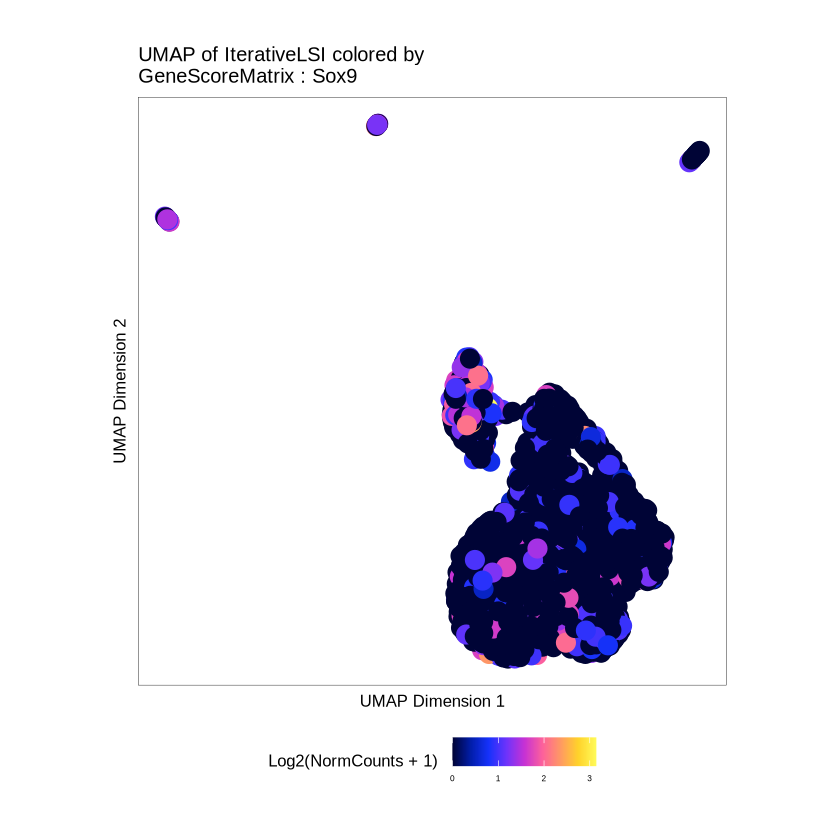

In [ ]:
plotEmbedding(ArchRProj = proj_epdsc,
              colorBy = 'GeneScoreMatrix',
              name = 'Sox9',
              embedding = "UMAP",
              size = 5, 
              rastr = TRUE,
              imputeWeights = getImputeWeights(proj_epdsc),
              quantCut = c(0.2, 0.8),
              plotAs = "points")


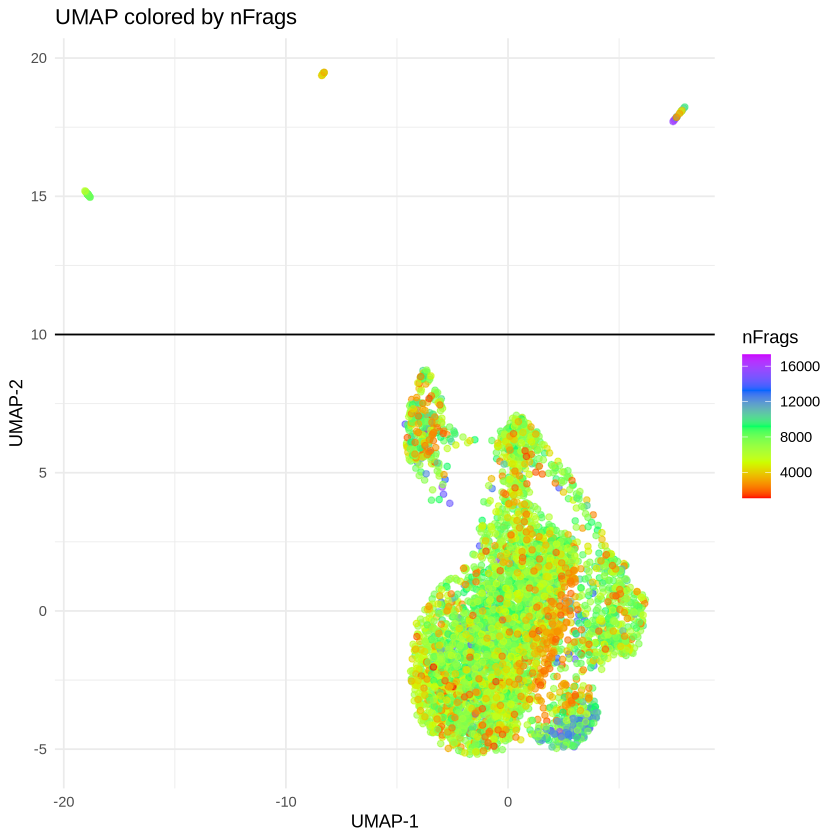

In [ ]:
umapEmbeddings <- getEmbedding(proj_epdsc, "UMAP")

cellData <- getCellColData(proj_epdsc)
reads_in_tss <- cellData$ReadsInTSS

# Prepare data frame for coloring UMAP by reads overlapping TSS
plotData <- data.frame(UMAP1 = umapEmbeddings[,1], UMAP2 = umapEmbeddings[,2], reads_in_tss = reads_in_tss)

library(ggplot2)

ggplot(plotData, aes(x = UMAP1, y = UMAP2, color = reads_in_tss)) +
  geom_point(alpha = 0.6) +
  scale_color_gradientn(colors = rainbow(5)) +
  labs(title = "UMAP colored by ReadsInTSS", x = "UMAP-1", y = "UMAP-2", color = "Reads in TSS") +
  theme_minimal()  +
    geom_hline(yintercept = 10)

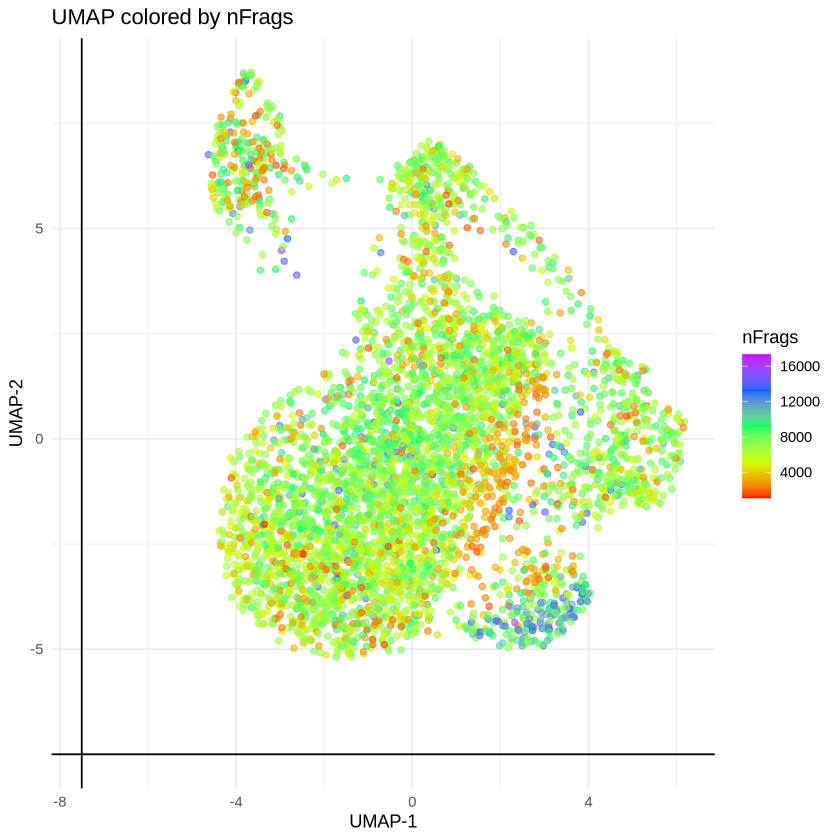

In [ ]:
# Filter outlier cells with low UMAP Y coordinate (possible immune/contaminant cluster)
idxPass <- which(proj_epdsc@embeddings$UMAP$df[,2] < 10)
cellsPass <- proj_epdsc$cellNames[idxPass]
proj_epdsc_filtered <- proj_epdsc[cellsPass, ]

umapEmbeddings <- getEmbedding(proj_epdsc_filtered, "UMAP")

cellData <- getCellColData(proj_epdsc_filtered)
reads_in_tss <- cellData$ReadsInTSS

# Prepare data frame for coloring UMAP by reads overlapping TSS
plotData <- data.frame(UMAP1 = umapEmbeddings[,1], UMAP2 = umapEmbeddings[,2], reads_in_tss = reads_in_tss)

library(ggplot2)

ggplot(plotData, aes(x = UMAP1, y = UMAP2, color = reads_in_tss)) +
  geom_point(alpha = 0.6) +
  scale_color_gradientn(colors = rainbow(5)) +
  labs(title = "UMAP colored by ReadsInTSS", x = "UMAP-1", y = "UMAP-2", color = "Reads in TSS") +
  theme_minimal()  +
    geom_vline(xintercept = -7.5) +
    #geom_vline(xintercept = 9.5) +
    geom_hline(yintercept = - 7.5) #+ 
    #geom_hline(yintercept = 8)

In [ ]:
# Recompute LSI/UMAP with more features on filtered subset
proj_epdsc_filtered <- addIterativeLSI(ArchRProj = proj_epdsc_filtered,
                        useMatrix = "TileMatrix",
                        name = "IterativeLSI2",
                        iterations = 3,
                        seed = 1,
                        clusterParams = list(resolution = c(0.2, 0.5),
                                             sampleCells = 3000,
                                             n.start = 10),
                        varFeatures = 30000,
                        dimsToUse = 1:30, force = TRUE)

# Clustering using IterativeLSI2
proj_epdsc_filtered <- addClusters(input = proj_epdsc_filtered,
                    reducedDims = "IterativeLSI2",
                    method = "Seurat",
                    name = "Clusters",
                    resolution = 0.2, force = TRUE)

# UMAP using IterativeLSI2
proj_epdsc_filtered <- addUMAP(ArchRProj = proj_epdsc_filtered,
                reducedDims = "IterativeLSI2",
                name = "UMAP",
                nNeighbors = 30,
                minDist = 0.5,
                metric = "cosine", force = TRUE)

plotEmbedding(ArchRProj = proj_epdsc_filtered, colorBy = "cellColData", size = 0.5, rastr = TRUE,
                    name = "Clusters", embedding = "UMAP", labelSize = 0)
plotEmbedding(ArchRProj = proj_epdsc_filtered, colorBy = "cellColData", size = 0.5, rastr = TRUE,
                    name = "Sample", embedding = "UMAP", labelSize = 0)


Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-1f91f4d9abb00-Date-2025-01-04_Time-23-24-28.598919.log
If there is an issue, please report to github with logFile!

2025-01-04 23:24:28.934653 : Computing Total Across All Features, 0.003 mins elapsed.

2025-01-04 23:24:29.736016 : Computing Top Features, 0.016 mins elapsed.

###########
2025-01-04 23:24:31.051498 : Running LSI (1 of 3) on Top Features, 0.038 mins elapsed.
###########

2025-01-04 23:24:31.066891 : Creating Partial Matrix, 0.039 mins elapsed.

2025-01-04 23:25:01.088145 : Computing LSI, 0.539 mins elapsed.

2025-01-04 23:25:31.47283 : Identifying Clusters, 1.045 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2025-01-04 23:25:35.420186 : Identified 5 Clusters, 1.111 mins elapsed.

2025-01-04 23:25:35.426682 : Saving LSI Iteration, 1.111 mins elapsed.






************************************************************
2025-01-04 23:25:47.715737 : ERROR Found in .saveIteration for  
LogFile = ArchRLogs/ArchR-addIterativeLSI-1f91f4d9abb00-Date-2025-01-04_Time-23-24-28.598919.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2025-01-04 23:25:47.717919 : Creating Cluster Matrix on the total Group Features, 1.316 mins elapsed.

2025-01-04 23:26:36.494452 : Computing Variable Features, 2.129 mins elapsed.

###########
2025-01-04 23:26:36.630918 : Running LSI (2 of 3) on Variable Features, 2.131 mins elapsed.
###########

2025-01-04 23:26:36.64722 : Creating Partial Matrix, 2.132 mins elapsed.

2025-01-04 23:26:57.862157 : Computing LSI, 2.485 mins elapsed.

2025-01-04 23:27:18.363728 : Identifying Clusters, 2.827 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2025-01-04 23:27:22.182756 : Identified 6 Clusters, 2.89 mins elapsed.

2025-01-04 23:27:22.188995 : Saving LSI Iteration, 2.891 mins elapsed.






************************************************************
2025-01-04 23:27:33.798021 : ERROR Found in .saveIteration for  
LogFile = ArchRLogs/ArchR-addIterativeLSI-1f91f4d9abb00-Date-2025-01-04_Time-23-24-28.598919.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2025-01-04 23:27:34.445943 : Creating Cluster Matrix on the total Group Features, 3.095 mins elapsed.

2025-01-04 23:28:20.920403 : Computing Variable Features, 3.869 mins elapsed.

###########
2025-01-04 23:28:21.072234 : Running LSI (3 of 3) on Variable Features, 3.872 mins elapsed.
###########

2025-01-04 23:28:21.08832 : Creating Partial Matrix, 3.872 mins elapsed.

2025-01-04 23:28:42.982992 : Computing LSI, 4.237 mins elapsed.

2025-01-04 23:29:07.438242 : Finished Running IterativeLSI, 4.645 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-addClusters-1f91f4c678707-Date-2025-01-04_Time-23-29-07.445726.log
If there is an issue, please report to github with logFile!

Overriding previous entry for Clusters

2025-01-04 23:29:07.595006 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4476
Number of edges: 148356

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8967
Number of communities: 6
Elapsed time: 0 seconds


2025-01-04 23:29:12.028671 : Testing Outlier Clusters, 0.075 mins elapsed.

2025-01-04 23:29:12.032701 : Assigning Cluster Names to 6 Clusters, 0.075 mins elapsed.

2025-01-04 23:29:12.065521 : Finished addClusters, 0.075 mins elapsed.

23:29:12 UMAP embedding parameters a = 0.583 b = 1.334

23:29:12 Read 4476 rows and found 30 numeric columns

23:29:12 Using Annoy for neighbor search, n_neighbors = 30

23:29:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:29:12 Writing NN index file to temp file /scratch/lsftmp/11530346.tmpdir/RtmplRqyL4/file1f91f53a0bd45

23:29:12 Searching Annoy index using 64 threads, search_k = 3000

23:29:13 Annoy recall = 100%

23:29:13 Commencing smooth kNN distance calibration using 64 threads
 with target n_neighbors = 30

23:29:14 Init

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f4ffab616-Date-2025-01-04_Time-23-31-11.829048.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f4ffab616-Date-2025-01-04_Time-23-31-11.829048.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1f91f70c681cd-Date-2025-01-04_Time-23-31-12.398887.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1f91f70c681cd-Date-2025-01-04_Time-23-31-12.398887.log



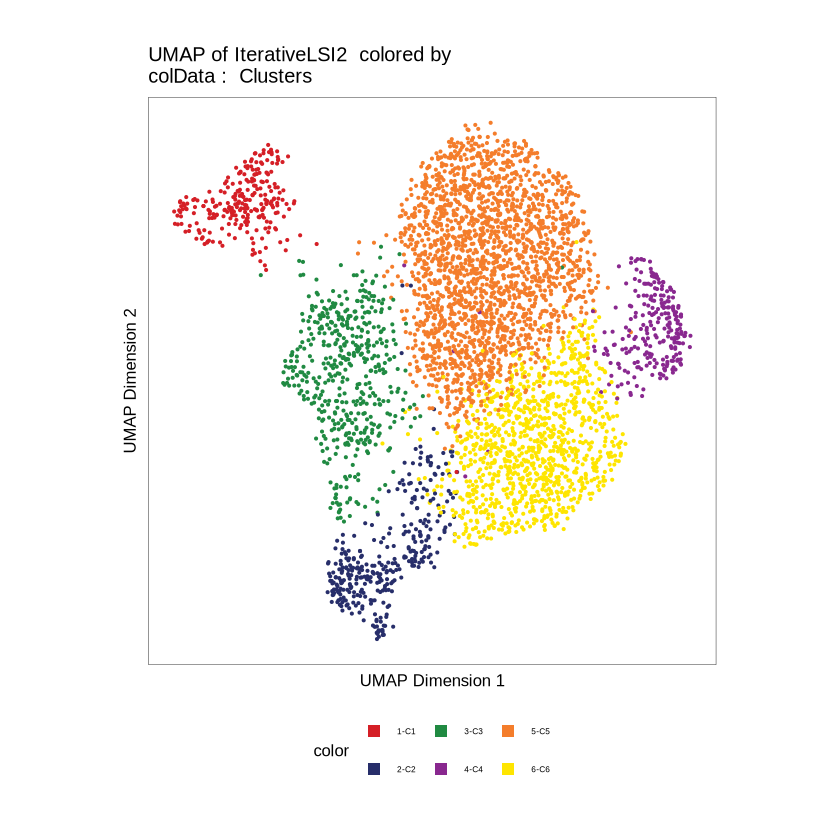

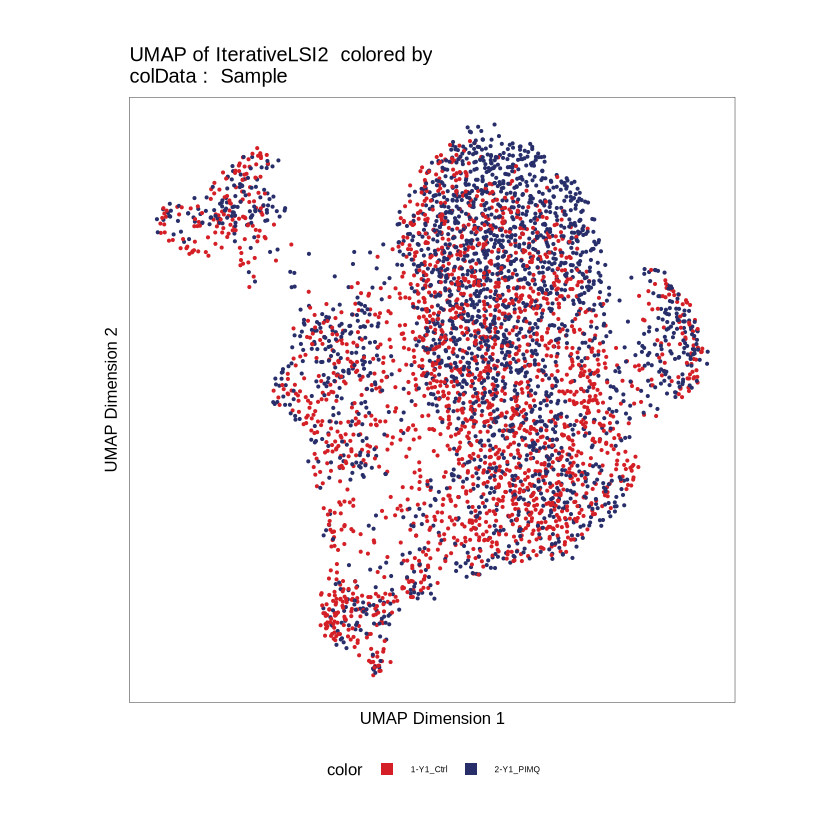

In [ ]:
plotEmbedding(ArchRProj = proj_epdsc_filtered, colorBy = "cellColData", size = 0.5, rastr = TRUE,
                    name = "Clusters", embedding = "UMAP", labelSize = 0)
plotEmbedding(ArchRProj = proj_epdsc_filtered, colorBy = "cellColData", size = 0.5, rastr = TRUE,
                    name = "Sample", embedding = "UMAP", labelSize = 0)

In [ ]:
proj_epdsc_filtered <- saveArchRProject(ArchRProj = proj_epdsc_filtered)

Copying Arrow Files...

Copying Arrow Files (1 of 2)

Copying Arrow Files (2 of 2)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `

In [ ]:
proj_epdsc_filtered@cellColData %>% as.data.frame() %>% group_by(Sample) %>% summarize(n = n())

Sample,n
<chr>,<int>
Y1_Ctrl,2182
Y1_PIMQ,2294


In [ ]:
proj_epdsc_filtered@cellColData

DataFrame with 4476 rows and 16 columns
                            Sample TSSEnrichment ReadsInTSS ReadsInPromoter
                             <Rle>       <array>    <array>         <array>
Y1_PIMQ#TACGCCTTCTCTGAGA-1 Y1_PIMQ        21.988      17322           59825
Y1_PIMQ#GTGATCAGTCCATTGA-1 Y1_PIMQ        20.931      14735           51260
Y1_PIMQ#AACAGTCGTATTCTGG-1 Y1_PIMQ        15.295       7500           26742
Y1_PIMQ#GATCGTAAGATGCGCA-1 Y1_PIMQ        22.287      16331           55795
Y1_PIMQ#TGGCAATCACCAAGGA-1 Y1_PIMQ        23.284      16215           57066
...                            ...           ...        ...             ...
Y1_Ctrl#GGAGTAGCAGGTAACG-1 Y1_Ctrl        24.101       1923            6910
Y1_Ctrl#GGTCATATCTGCCGAG-1 Y1_Ctrl        26.701       2508            7947
Y1_Ctrl#TCAGTTTTCTTCTCTC-1 Y1_Ctrl        15.967       1395            5073
Y1_Ctrl#TTACCGCTCAAGTTGC-1 Y1_Ctrl        25.721       2351            8262
Y1_Ctrl#CAGCCTTTCAACACGT-1 Y1_Ctrl        19.386